# CSV File - Categorical and Numerical Columns in Tensorflow

This demo takes a CSV file (can be on object store with a pre-authenticated URL) and uses different encoders to train a sequential model.

See the following demo on categorical columns in tensorflow:
https://www.tensorflow.org/tutorials/structured_data/feature_columns

In this tutorial we predict the banking crisis.

We use:

* LabelEncoder to encode no_crisis, cris values in banking_crisis field, this our output Y vector for prediction
* OneHot encoding to encode country name (Kenya, Egypt, etc.)
* Feature vector construction by selecting columns of interest: inflation_annual_cpi, year, dollar exchange ratio, etc.

In [1]:
import pandas as pd
data=pd.read_csv('../datasets/african_crises.csv')
data.sample(5)




,case,cc3,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
190,10,CAF,Central African Republic,1985,0,378.049733,0,1,0.0,10.457000,1,0,0,no_crisis
453,35,KEN,Kenya,1963,0,7.142900,0,0,0.0,0.000000,1,0,0,no_crisis
479,35,KEN,Kenya,1989,1,21.601000,0,0,0.0,7.617000,1,1,0,no_crisis
340,19,EGY,Egypt,1917,0,0.204900,0,0,0.0,35.480022,1,0,1,no_crisis
627,40,MAR,Morocco,1994,0,8.959600,0,0,0.0,5.142000,1,0,0,no_crisis


In [2]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


# Specify the Object Stores pre-authenticated URL
#fp = tf.keras.utils.get_file(fname='/root/african_crises_copy.csv', origin='file:/root/african_crises.csv')

train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')




677 train examples
170 validation examples
212 test examples


In [15]:
# Vocabulary for output columns
#banking_crisis_voc = data['banking_crisis'].unique()


# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('banking_crisis')
  le = LabelEncoder()
  le.fit(labels)
  Y=le.transform(labels)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), Y))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

batch_size = 32 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

#display(train_ds)
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of inflation cpi:', feature_batch['inflation_annual_cpi'])
  print('A batch of targets:', label_batch )



Every feature: ['case', 'cc3', 'country', 'year', 'systemic_crisis', 'exch_usd', 'domestic_debt_in_default', 'sovereign_external_debt_default', 'gdp_weighted_default', 'inflation_annual_cpi', 'independence', 'currency_crises', 'inflation_crises']
A batch of inflation cpi: tf.Tensor(
[ 2.84975748  1.30776708 15.35621451  7.617       1.392      17.06
  4.95        5.93957349  4.54479533 11.2        13.12090131  9.38864629
  8.903      -3.95519429  2.745      38.1935295  23.61111111  9.52760733
 -1.02849238 -3.11280343 31.7         2.857       1.80188446 38.50391131
 -0.32243718  7.835       1.89309577 -6.21694442  2.42410266  3.723
  8.65        7.59986814], shape=(32,), dtype=float64)
A batch of targets: tf.Tensor([1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1], shape=(32,), dtype=int64)


In [4]:
feature_columns = []

#TODO: independence, inflation crises is category column with identity

# numeric cols
for header in ['inflation_annual_cpi', 'year', 'exch_usd', 'gdp_weighted_default', 'independence', 'inflation_crises', 'domestic_debt_in_default']:
  feature_columns.append(feature_column.numeric_column(header))
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# Vocabulary
countries_voc = data['country'].unique()

country = feature_column.categorical_column_with_vocabulary_list(
      'country', countries_voc)
country_one_hot = feature_column.indicator_column(country)
feature_columns.append(country_one_hot)
display(feature_columns)




[NumericColumn(key='inflation_annual_cpi', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='year', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='exch_usd', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='gdp_weighted_default', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='independence', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='inflation_crises', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='domestic_debt_in_default', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='country', vocabulary_list=('Algeria', 'Angola', 'Central African Republic', 'Ivory Coast', 'Egypt', 'Kenya', 'Mauritius', 'Morocco', 'Nigeria', 'South Africa', 'Tuni

In [9]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=50)


Epoch 1/50
22/22 [==============================] - 0s 14ms/step - loss: 10.7945 - accuracy: 0.7829 - val_loss: 9.4009 - val_accuracy: 0.9235
Epoch 2/50
22/22 [==============================] - 0s 6ms/step - loss: 7.6987 - accuracy: 0.8671 - val_loss: 2.8293 - val_accuracy: 0.9235
Epoch 3/50
22/22 [==============================] - 0s 7ms/step - loss: 2.0175 - accuracy: 0.8567 - val_loss: 0.3696 - val_accuracy: 0.9059
Epoch 4/50
22/22 [==============================] - 0s 5ms/step - loss: 2.3591 - accuracy: 0.8493 - val_loss: 1.6027 - val_accuracy: 0.9235
Epoch 5/50
22/22 [==============================] - 0s 6ms/step - loss: 2.2666 - accuracy: 0.8360 - val_loss: 2.2366 - val_accuracy: 0.9235
Epoch 6/50
22/22 [==============================] - 0s 6ms/step - loss: 1.9021 - accuracy: 0.8626 - val_loss: 0.7291 - val_accuracy: 0.8706
Epoch 7/50
22/22 [==============================] - 0s 5ms/step - loss: 0.6296 - accuracy: 0.8582 - val_loss: 1.2603 - val_accuracy: 0.9235
Epoch 8/50
22/22 [

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)


<Figure size 432x288 with 0 Axes>

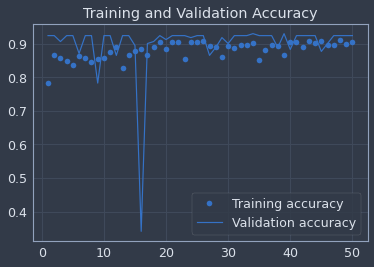

<Figure size 432x288 with 0 Axes>

In [11]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

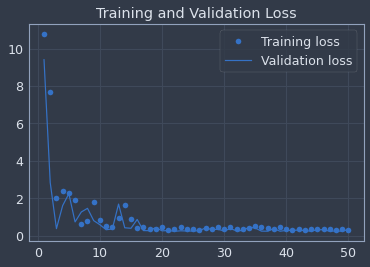

<Figure size 432x288 with 0 Axes>

In [12]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.figure()